# Environment

In [14]:
import os
import json
import logging
import warnings
from pathlib import Path
from typing import List, Tuple, Dict

# configure environment variables
secret = json.load(open(Path(Path.home(), "GPT-Sentinel/secret.json")))
os.environ["WANDB_NOTEBOOK_NAME"] = "main.ipynb"
os.environ['WANDB_API_KEY'] = secret['WANDB_API_KEY']

# filtered output
logging.getLogger('fairseq').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

import torch
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel


In [15]:
trainConfig = {
    "identifier": "roberta.base_0417",
    "epochIter": 15,
    "batchSize": 512/4,
    "dataset": {
        "batchSize": 64,
        "numWorkers": 8,
        "webFolder": Path(Path.home(), "GPT-Sentinel/data/open-web-text-split"),
        "gptFolder": Path(Path.home(), "GPT-Sentinel/data/open-gpt-text-split"),
    },
    "optimizer": {
        "learnRate": 1e-4,
        "weightDecay": 1e-3,
        "identity": "optim.AdamW",
    },
    "scheduler": {
        "T_max": 15,
        "eta_min": 1e-6,
    },
}


# Dataset

In [16]:
class DualDataset(torch.utils.data.Dataset):
    def __init__(self, partition: str) -> None:
        super().__init__()

        web, gpt = [], []
        # load from filesystem
        web_text = pd.read_json(Path(trainConfig["dataset"]['webFolder'], f"{partition}.jsonl"), lines=True)
        gpt_text = pd.read_json(Path(trainConfig["dataset"]["gptFolder"], f"{partition}.jsonl"), lines=True)
        web.extend(web_text["text"].tolist())
        gpt.extend(gpt_text["text"].tolist())
        assert len(web) == len(gpt)

        # label accordingly
        self.data = [(t, 0) for t in web] + [(t, 1) for t in gpt]
        self.length = len(self.data)

    def __len__(self, ) -> int:
        return self.length

    def __getitem__(self, index: int) -> Tuple[str, str]:
        return self.data[index]


In [17]:
# validation dataset
validDataset = DualDataset(
    partition="valid"
)

validLoader = torch.utils.data.DataLoader(
    dataset=validDataset,
    batch_size=trainConfig["dataset"]["batchSize"],
    num_workers=trainConfig["dataset"]["numWorkers"],
)


# Model

In [18]:
class Sentinel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        """
        Roberta is passive, with classification layer attached at the end.
        """

        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
        for param in self.roberta.parameters(): param.requires_grad = False
        
        self.fc = nn.Sequential(
            nn.Linear(768, 768), nn.GELU(),
            nn.Dropout(0.25), 
            nn.Linear(768, 2)
        )
        
    def forward(self, textBatch: Tuple) -> torch.Tensor:
        
        # ensure text of same length
        encodedText = self.tokenizer(
            textBatch, max_length=512, truncation=True, 
            padding="max_length", return_tensors="pt",
        ).to("cuda")

        lastHiddenStates = self.roberta(**encodedText).last_hidden_state

        # take <s> token (equiv. to [CLS]) to classify
        logits = self.fc(lastHiddenStates[:, 0, :])
        return logits


In [19]:
identifier = trainConfig["identifier"]
directory = Path(f"./storage/{identifier}")

model = Sentinel().to("cuda")
state = torch.load(Path(directory, "state.pt"))
model.load_state_dict(state["model"])


<All keys matched successfully>

In [20]:
# def get_confi(a):
#     return torch.nn.functional.softmax(a,-1)

# for text, label in (iter(validLoader)):
#     logits = model(text)
#     pure_confi = get_confi(logits)
#     conf_cat.append(pure_confi)
# torch.cat(conf_cat, 0)
# torch.save(conf_cat, Path(directory, "confidence.pt"))


In [21]:
def get_confi_i(a, label, i):
    sftmx =  torch.nn.functional.softmax(a,-1)
    col = sftmx[:,0]
    num = 64 - torch.sum(label)
    flip = torch.where(label == 0, 1.0, 0.0).to("cuda")
    res = torch.dot(col, flip)
    return (torch.sum(res).item(), i + num)

def get_confi_j(a, label, i):
    sftmx =  torch.nn.functional.softmax(a,-1)
    col = sftmx[:,1]
    num = torch.sum(label)
    flip = torch.where(label == 1, 1.0, 0.0).to("cuda")
    res = torch.dot(col, flip)
    return (torch.sum(res).item(), i + num)

def get_confi(a):
    sftmx = torch.nn.functional.softmax(a,-1)
    return sftmx
web_sum = 0
gpt_sum = 0
i = 0
j = 0
model.eval()
conf_cat0 = []
conf_cat1 = []
for text, label in tqdm(validLoader, desc="looping", total=len(validLoader)):
    logits = model(text)
    flag0 = True
    flag1 = True
    for i in label:
        if i.item() == 1: flag0 = False
        if i.item() == 0: flag1 = False
    if flag0 == True:
        pure_confi = get_confi(logits)
        conf_cat0.append(pure_confi.detach().cpu())
    if flag1 == True:
        pure_confi = get_confi(logits)
        conf_cat1.append(pure_confi.detach().cpu())
    # new_res_web, i = get_confi_i(logits,label, i)
    # web_sum+=new_res_web
    # new_res_gpt, j = get_confi_j(logits,label, j)
    # gpt_sum+=new_res_gpt

torch.cat(conf_cat0, 0)
print(conf_cat0)
torch.cat(conf_cat1, 0)
print(conf_cat1)
# print(str((web_sum/i).item())+"  "+str((gpt_sum/j).item()))
# torch.save(conf_cat, Path(directory, "confidence.pt"))


looping: 100%|██████████| 92/92 [01:21<00:00,  1.13it/s]

[tensor([[0.9792, 0.0208],
        [0.8751, 0.1249],
        [0.9789, 0.0211],
        [0.8631, 0.1369],
        [0.5912, 0.4088],
        [0.6937, 0.3063],
        [0.8888, 0.1112],
        [0.8592, 0.1408],
        [0.8925, 0.1075],
        [0.9392, 0.0608],
        [0.5651, 0.4349],
        [0.8827, 0.1173],
        [0.9855, 0.0145],
        [0.6386, 0.3614],
        [0.9215, 0.0785],
        [0.9754, 0.0246],
        [0.9780, 0.0220],
        [0.9940, 0.0060],
        [0.9072, 0.0928],
        [0.8814, 0.1186],
        [0.8152, 0.1848],
        [0.9149, 0.0851],
        [0.9825, 0.0175],
        [0.9797, 0.0203],
        [0.8362, 0.1638],
        [0.9462, 0.0538],
        [0.9039, 0.0961],
        [0.8625, 0.1375],
        [0.9333, 0.0667],
        [0.7632, 0.2368],
        [0.8765, 0.1235],
        [0.9980, 0.0020],
        [0.4385, 0.5615],
        [0.8175, 0.1825],
        [0.9643, 0.0357],
        [0.8441, 0.1559],
        [0.9529, 0.0471],
        [0.8212, 0.1788],
        [0.

In [22]:
a = torch.tensor([0]*10).to("cuda")

for i in conf_cat0:
    for j in i:
        x = j[0].item()*100
        # b = i[j][1].item*100
        a[int(x//10)]+=1

print(a)
    


tensor([  19,   40,   59,   94,   90,  139,  201,  266,  494, 1478],
       device='cuda:0')


In [23]:
b = torch.tensor([0]*10).to("cuda")

for i in conf_cat1:
    for j in i:
        x = j[1].item()*100
        # b = i[j][1].item*100
        b[int(x//10)]+=1

print(b)
    


tensor([   5,   11,   30,   28,   46,   97,  160,  285,  571, 1699],
       device='cuda:0')


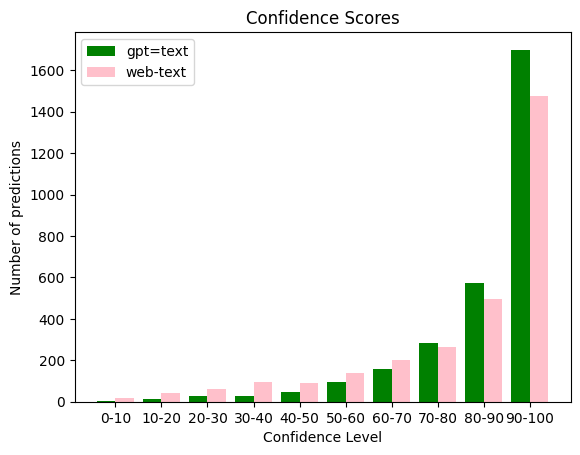

In [38]:
import matplotlib.pyplot as plt

# sample data
# x = torch.Tensor.tolist(a)
x = ["0-10","10-20","20-30","30-40","40-50","50-60","60-70","70-80","80-90","90-100"]
y1 = torch.Tensor.tolist(b)
y2 = torch.Tensor.tolist(a)
# label x-axis
plt.xticks(range(len(x)), x)

plt.bar([i-0.2 for i in range(len(x))], y1, width=0.4, color='green', align='center', label='gpt=text')
plt.bar([i+0.2 for i in range(len(x))], y2, width=0.4, color='pink', align='center', label='web-text')


# add labels and title
plt.xlabel('Confidence Level')
plt.ylabel('Number of predictions')
plt.title('Confidence Scores (roberta)')

# add legend
plt.legend()


# show the chart
plt.show()
